In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import CubicSpline, interp1d
from scipy.linalg import svd
from tqdm import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from numpy.fft import rfft, rfftfreq
from scipy.signal import argrelmax, stft, periodogram
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

# 1. Explore Data

In [4]:
data = pd.read_csv('X_train.csv')
data.set_index("Horodate", inplace=True)
data.drop(columns=["holed_192"], inplace=True)

In [11]:
data_train = pd.read_csv('y_train.csv')
data_train.set_index("Horodate", inplace=True)
data_train.dropna(axis=1, inplace=True)
data_train.isnull().sum().max() # Check qu'il n'y a aucune donnée manquante dans ce dataframe

np.int64(0)

In [12]:
for col in data_train.columns:
    if data_train[col].isnull().sum() != 0:
        print(col)

### ---

In [13]:
df_test = pd.read_csv('X_test.csv')
df_test.set_index('Horodate', inplace=True)

### ---

In [221]:
feature_TS_train = [col for col in data.columns if 'holed' not in col]
holed_T_train  = [col for col in data.columns if 'holed' in col]
feature_TS_test = [col for col in df_test.columns if 'holed' not in col]
holed_T_test  = [col for col in df_test.columns if 'holed' in col]

df_test_complete = df_test.loc[:,feature_TS_test].dropna(axis=1).copy()
df_test_missing = df_test.loc[:,holed_T_test].copy()
complete_TS = data.loc[:,feature_TS_train].copy()
TS_missing = data.loc[:,holed_T_train].copy()
# common_columns = complete_TS.columns.intersection(df_test_complete.columns)
# complete_TS = complete_TS[common_columns]
# df_test_complete = df_test_complete[common_columns]

In [178]:
# Séparer les séries en 80% train et 20% test
train_series, test_series = train_test_split(TS_missing.columns, test_size=0.2, random_state=42)

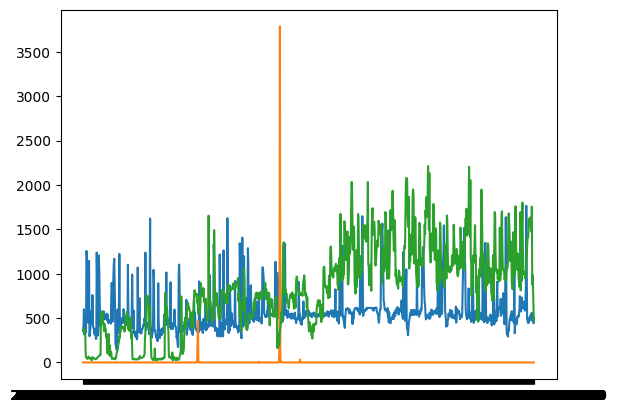

In [13]:
plt.plot(data.iloc[:,0])
plt.plot(data.iloc[:,1])
plt.plot(data.iloc[:,2])

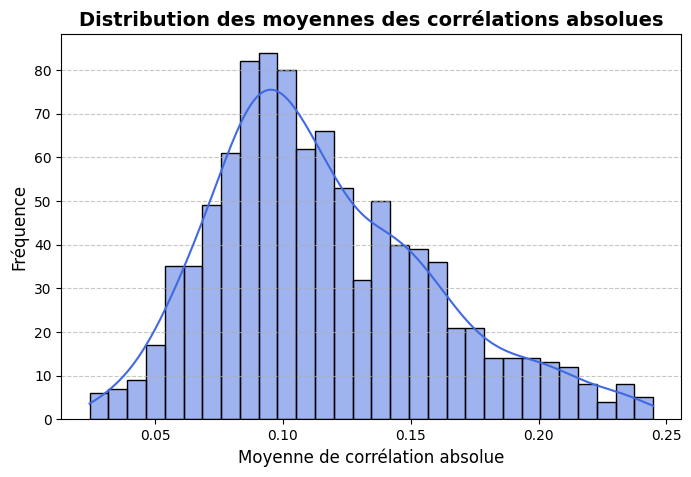

In [56]:
corr_test = data.sample(n=1000, axis=1).corr()
corr_mean = corr_test.abs().mean()

# Création de l'histogramme avec une meilleure visualisation
plt.figure(figsize=(8, 5))
sns.histplot(corr_mean, bins=30, kde=True, color="royalblue", edgecolor="black")

# Ajout des titres et labels
plt.title("Distribution des moyennes des corrélations absolues", fontsize=14, fontweight="bold")
plt.xlabel("Moyenne de corrélation absolue", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)

# Ajout d'une grille
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("plots_raport/histo_correlations.png", dpi=500)
# Affichage du plot
plt.show()

In [15]:
col = -1
data.iloc[:,col][data.iloc[:,col].isna()].shape[0]

219

In [16]:
n = 10
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna()

5423908671    0.056926
2568793410    0.011136
8310762594    0.262633
6235194807   -0.125170
423895617     0.232911
193845276     0.044566
216589743     0.192563
218753964    -0.259729
1794650328    0.062698
9253476180    0.014752
Name: holed_1000, dtype: float64

In [18]:
n = 1000
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna().abs().max()

np.float64(0.32969211548761196)

In [19]:
n = 100
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna().abs().argmax()

np.int64(2)

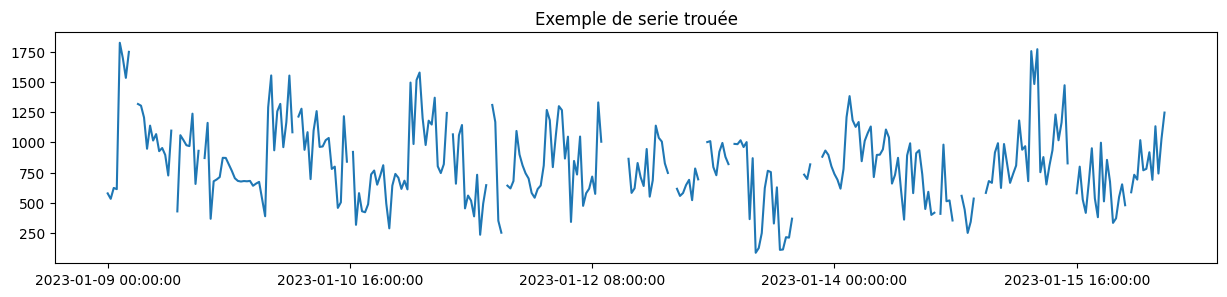

In [54]:
fig, ax = fig_ax()
plt.plot(TS_missing.iloc[:350,0])
plt.title("Exemple de serie trouée")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.savefig("plots_raport/exemple_serie_trouée.png",dpi=500)
plt.show()

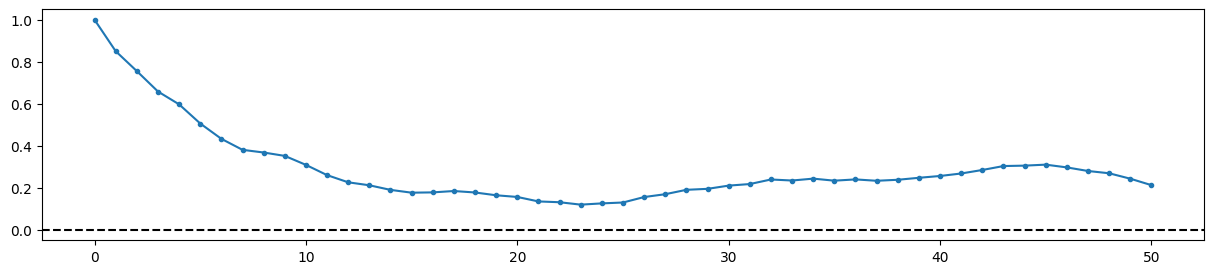

In [374]:
fig, ax = fig_ax()
ax.plot(acf(TS_missing.iloc[:,3].dropna(), nlags=50, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

0it [00:00, ?it/s]/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
50it [00:00, 5191.61it/s]


OK


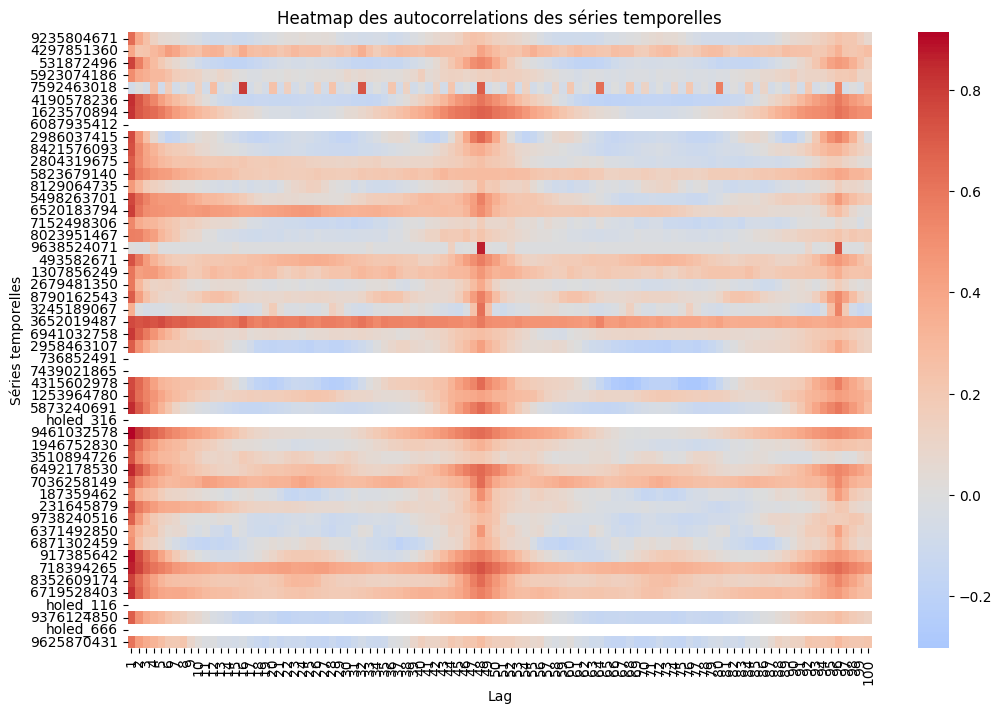

In [55]:
np.random.seed(42)
n_series = 50
sample_data = data.sample(n=n_series,axis=1).copy()

# Calcul des autocorrelations à différents lags
lags = 100  # Nombre de lags à afficher
autocorr_matrix = np.zeros((n_series, lags))

for i, col in tqdm(enumerate(sample_data.columns)):
    autocorr_matrix[i, :] = acf(sample_data.loc[:,col], nlags=lags, fft=True)[1:]  # Exclut le lag 0 (corrélation parfaite)
print('OK')
# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(autocorr_matrix, cmap="coolwarm", center=0, xticklabels=range(1, lags+1), yticklabels=sample_data.columns)
plt.xlabel("Lag")
plt.ylabel("Séries temporelles")
plt.title("Heatmap des autocorrelations des séries temporelles")
plt.savefig('plots_raport/acf.png',dpi=500)
plt.show()

In [22]:
nan_count_per_column = complete_TS.isnull().sum()
print(nan_count_per_column.max())

nan


In [22]:
FREQUENCY = 49
f, t, Zxx = stft(df_test_complete.iloc[:,1], fs=FREQUENCY, nperseg=1000, noverlap=800)

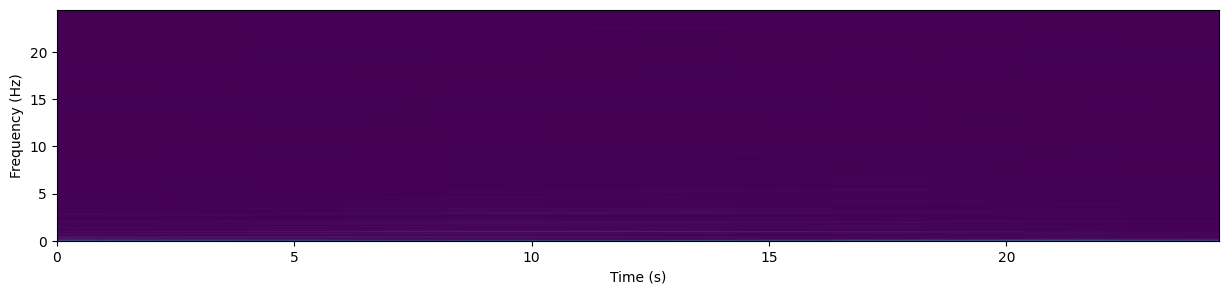

In [23]:
fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

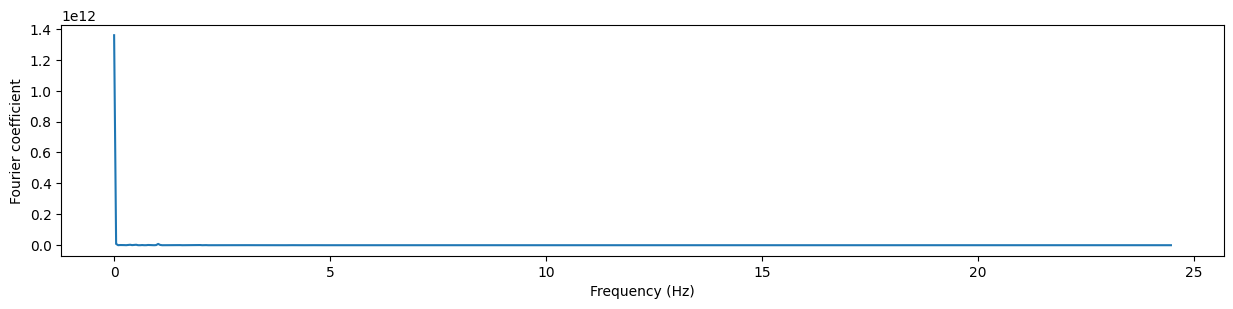

In [25]:
n_samples = df_test_complete.shape[0]
fourier = abs(rfft(df_test_complete.iloc[:,1])) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

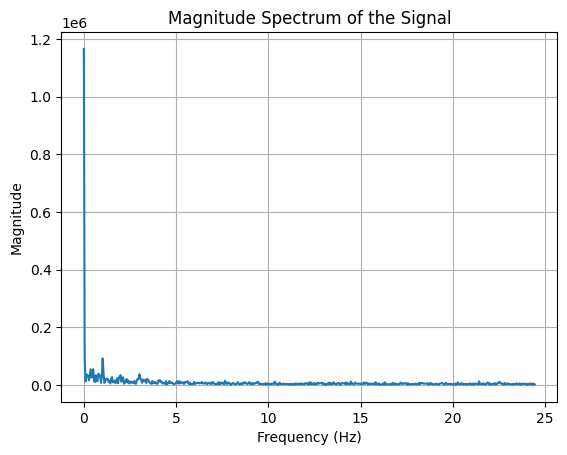

In [28]:
fs = 49
# Compute the DFT of the signal
dft = np.fft.fft(df_test_complete.iloc[:,1])
# Frequency bins
frequencies = np.fft.fftfreq(len(df_test_complete.iloc[:,1]), 1 / fs)

# Plot the magnitude spectrum
plt.plot(frequencies[:len(frequencies) // 2], np.abs(dft)[:len(dft) // 2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum of the Signal")
plt.grid(True)
plt.show()

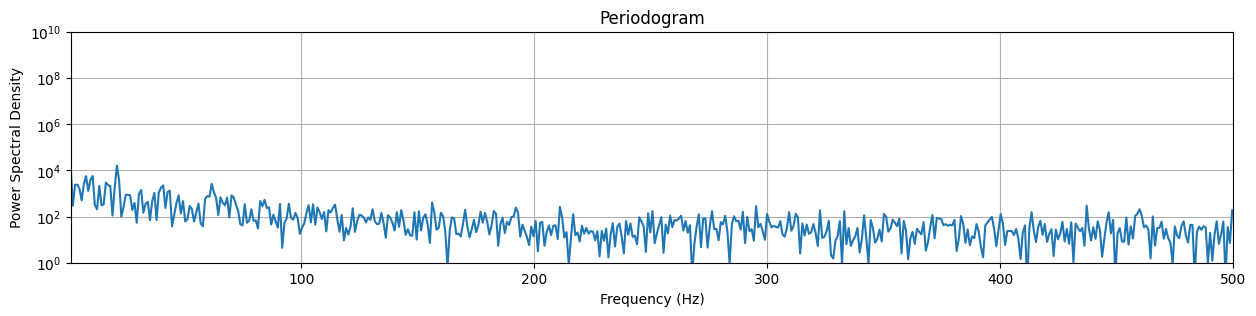

In [31]:
# Compute the periodogram
fig, ax = fig_ax()
frequencies, power_spectrum = periodogram(df_test_complete.iloc[:,1], 1000)

# Plot the periodogram
# plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power_spectrum)
plt.xlim((1,500))
plt.ylim((10e-1,10e9))
plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

In [32]:
frequencies[power_spectrum.argmax()]

np.float64(0.946073793755913)

In [ ]:
def longest_missing_segment(series):
    """
    Trouve la plus grande portion consécutive de données manquantes (NaN) dans une série temporelle.

    Paramètres :
    - series : array-like (pandas Series ou numpy array), la série temporelle.

    Retourne :
    - max_gap : longueur de la plus grande séquence continue de NaN.
    """
    is_nan = np.isnan(series)  # Masque booléen des NaN
    max_gap = 0  # Longueur max de la séquence de NaN
    current_gap = 0  # Compteur temporaire

    for missing in is_nan:
        if missing:
            current_gap += 1  # Incrémentation si NaN
        else:
            max_gap = max(max_gap, current_gap)  # Mise à jour du max
            current_gap = 0  # Réinitialisation si valeur valide

    # Vérification à la fin (si la série se termine par des NaN)
    max_gap = max(max_gap, current_gap)

    return max_gap

In [43]:
def longest_nan_sequence(series):
    """
    Fonction pour détecter les longueurs des séquences de NaN dans une série.
    
    Paramètre :
    - series : np.array ou pandas.Series

    Retourne :
    - Une liste contenant la taille de chaque patch de NaN.
    """
    nan_lengths = []
    current_length = 0
    
    for value in series:
        if np.isnan(value):
            current_length += 1
        else:
            if current_length > 0:
                nan_lengths.append(current_length)
                current_length = 0
    
    if current_length > 0:  # Ajout du dernier patch si nécessaire
        nan_lengths.append(current_length)
    
    return nan_lengths

In [45]:
gaps = []
for col in TS_missing.columns:
    gaps += longest_nan_sequence(TS_missing[col])

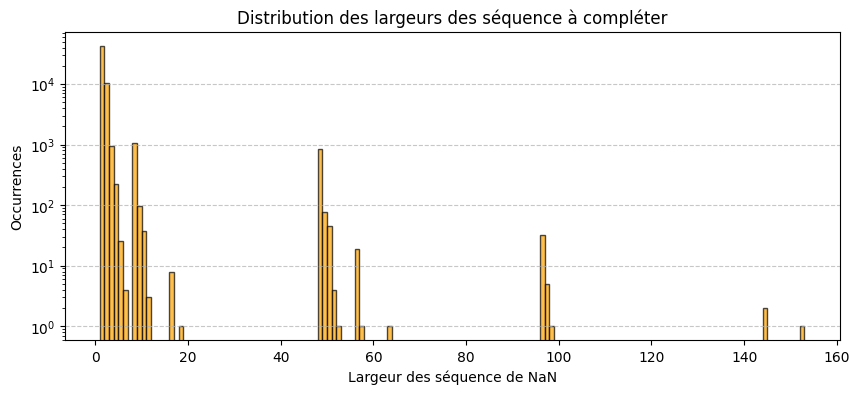

In [53]:
plt.figure(figsize=(10,4))
plt.hist(gaps, bins=range(1, max(gaps)+2), edgecolor='black', alpha=0.7, color='orange')
plt.xlabel("Largeur des séquence de NaN")
plt.ylabel("Occurrences")
plt.title("Distribution des largeurs des séquence à compléter")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.savefig('plots_raport/distribution_patch.png', dpi=500)
plt.show()

# Testing Models

## 1. Interpolation

In [58]:
# 📌 Filtrer les colonnes trouées
data_train_interpolate = data_train.reset_index(drop=True)
TS_missing_interpolate = TS_missing.reset_index(drop=True)
columns_holed = [col for col in test_series if 'holed_' in col]

# 📌 Initialiser les DataFrames pour stocker les interpolations
df_cubic = TS_missing_interpolate.copy()
df_spline = TS_missing_interpolate.copy()
df_linear = TS_missing_interpolate.copy()

mae_cubic_total = []
mae_spline_total = []
mae_linear_total = []

# 📌 Boucle sur chaque série trouée
for col in columns_holed:
    # Indices des valeurs connues
    valid_idx = TS_missing_interpolate[col].dropna().index.astype(float)
    
    # Interpolation Cubique
    cubic_interp = interp1d(valid_idx, TS_missing_interpolate[col].dropna(), kind="cubic", fill_value="extrapolate")
    df_cubic[col] = cubic_interp(TS_missing_interpolate.index.astype(float))
    
    # Interpolation Spline
    spline_interp = CubicSpline(valid_idx, TS_missing_interpolate[col].dropna())
    df_spline[col] = spline_interp(TS_missing_interpolate.index.astype(float))
    
    # Interpolation Linéaire
    linear_interp = interp1d(valid_idx,  TS_missing_interpolate[col].dropna(), kind="linear", fill_value="extrapolate")
    df_linear[col] = linear_interp(TS_missing_interpolate.index.astype(float))
    
    # Calcul des erreurs uniquement sur les valeurs manquantes
    missing_idx = TS_missing_interpolate[TS_missing_interpolate[col].isna()].index
    mae_cubic = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_cubic.loc[missing_idx, col])
    mae_spline = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_spline.loc[missing_idx, col])
    mae_linear = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_linear.loc[missing_idx, col])
    
    mae_cubic_total.append(mae_cubic)
    mae_spline_total.append(mae_spline)
    mae_linear_total.append(mae_linear)

# 📌 Afficher les MAE moyennes sur toutes les séries
print(f"📊 MAE Moyenne sur {len(columns_holed)} séries :")
print(f"➡️  Interpolation Cubique  : {np.mean(mae_cubic_total):.4f}")
print(f"➡️  Interpolation Spline   : {np.mean(mae_spline_total):.4f}")
print(f"➡️  Interpolation Linéaire : {np.mean(mae_linear_total):.4f}")

# 📌 Sauvegarde des interpolations
df_cubic.to_csv("results/interpolation_cubic_all.csv")
df_spline.to_csv("results/interpolation_spline_all.csv")
df_linear.to_csv("interpolation_linear_all.csv")

print("✅ Interpolations terminées et fichiers sauvegardés !")

📊 MAE Moyenne sur 200 séries :
➡️  Interpolation Cubique  : 29038.1561
➡️  Interpolation Spline   : 29038.1561
➡️  Interpolation Linéaire : 107.7838
✅ Interpolations terminées et fichiers sauvegardés !


## 2. Low Rank Adaptation

In [57]:
def longest_missing_segment(series):
    """
    Trouve la plus grande portion consécutive de données manquantes (NaN) dans une série temporelle.

    Paramètres :
    - series : array-like (pandas Series ou numpy array), la série temporelle.

    Retourne :
    - max_gap : longueur de la plus grande séquence continue de NaN.
    """
    is_nan = np.isnan(series)  # Masque booléen des NaN
    max_gap = 0  # Longueur max de la séquence de NaN
    current_gap = 0  # Compteur temporaire

    for missing in is_nan:
        if missing:
            current_gap += 1  # Incrémentation si NaN
        else:
            max_gap = max(max_gap, current_gap)  # Mise à jour du max
            current_gap = 0  # Réinitialisation si valeur valide

    # Vérification à la fin (si la série se termine par des NaN)
    max_gap = max(max_gap, current_gap)

    return max_gap

In [89]:
def create_trajectory_matrix(series, window_size):
    """
    Transforme une série temporelle en matrice de trajectoire (Hankel matrix).
    """
    n = len(series)
    num_rows = n - window_size + 1
    trajectory_matrix = np.array([series[i:i+window_size] for i in range(num_rows)])
    return trajectory_matrix

def reconstruct_missing_values(X, W, rank=5, max_iter=1000, tol=1e-4):
    """
    Applique la factorisation de rang réduit (Low-Rank Approximation) pour compléter les valeurs manquantes.
    
    X : Matrice de trajectoire avec des valeurs manquantes.
    W : Matrice masque (1 = valeur connue, 0 = valeur manquante).
    rank : Rang attendu pour l'approximation.
    max_iter : Nombre maximal d'itérations.
    tol : Tolérance pour l'arrêt.
    """
    # Initialisation avec les valeurs connues
    X_hat = np.copy(X)
    #X_hat[W == 0] = np.nanmean(X)  # Remplacement initial des NaN par la moyenne

    for _ in range(max_iter):
        # Étape SVD
        U, S, Vt = svd(X * W + X_hat * (1 - W), full_matrices=False)
        
        # Approximation de rang réduit
        S[rank:] = 0  # On garde seulement les `rank` premiers éléments de S
        X_new = U @ np.diag(S) @ Vt
        
        # Vérification de la convergence
        error = np.linalg.norm((X_new - X_hat) * (1 - W)) / np.linalg.norm(X_new)
        X_hat = X_new
        
        if error < tol:
            break

    return X_hat

def recontruct_from_trajectory_matrix(trajectory_matrix):
    
    L, W = trajectory_matrix.shape  # L = nombre de lignes (fenêtres), W = taille de la fenêtre
    reconstructed_series = np.zeros(L + W - 1)  # Série temporelle finale
    counts = np.zeros(L + W - 1)  # Compteur pour la moyenne sur les recouvrements
    
    for i in range(L):
        reconstructed_series[i:i+W] += trajectory_matrix[i]  # Ajout des valeurs de la fenêtre
        counts[i:i+W] += 1  # Comptage du nombre de fois où un point est inclus
        
    reconstructed_series /= counts
    return reconstructed_series

def complete_time_series(series, window_size):
    """
    Complète une série temporelle en appliquant le Low-Rank Adaptation sur la matrice de trajectoire.
    
    series : Série temporelle avec des valeurs manquantes.
    window_size : Taille de la fenêtre pour la matrice de trajectoire.
    rank : Rang pour la factorisation.
    """
    # Construction de la matrice de trajectoire
    rank = int(window_size*0.4)
    trajectory_matrix = create_trajectory_matrix(series, window_size)
    
    # Création de la matrice masque W
    W = (~np.isnan(trajectory_matrix)).astype(float)
    
    # Remplacement temporaire des NaN pour éviter les erreurs de calcul
    X = np.nan_to_num(trajectory_matrix, nan=1)

    # Reconstruction de la matrice complétée
    X_completed = reconstruct_missing_values(X, W, rank=rank)

    # Reconstruction de la série temporelle
    reconstructed_series = recontruct_from_trajectory_matrix(X_completed)

    return reconstructed_series

completed_serie = complete_time_series(TS_missing.loc[:,"holed_8"], int(1.5*longest_missing_segment(TS_missing.loc[:,"holed_1"])))

In [90]:
completed_serie

array([663.25058158, 494.25487713, 413.71394051, ..., 343.98386606,
       832.6264322 , 771.297458  ])

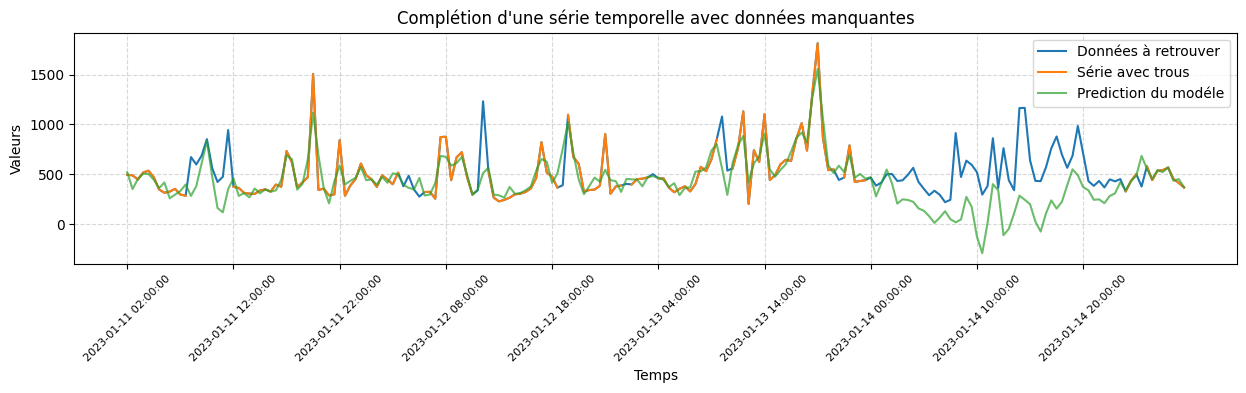

In [101]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:300], alpha=1, label='Données à retrouver')
ax.plot(TS_missing["holed_8"][100:300], label='Série avec trous')
ax.plot(completed_serie[100:300], alpha=0.7, label='Prediction du modéle')
ax.set_xticks(range(0, 200, 20))  # Affichage tous les 10 points
ax.set_xticklabels(data_train.index[100:300:20], rotation=45, fontsize=8)  # Rotation pour lisibilité
ax.set_title("Complétion d'une série temporelle avec données manquantes")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeurs")

# Ajout d'une grille légère
ax.grid(True, linestyle='--', alpha=0.5)

# Ajout d'une légende
ax.legend()
plt.savefig('plots_raport/Lora.png', dpi=500)
plt.show()

In [102]:
serie_list = []
for serie in tqdm(test_series):
    serie_list.append(complete_time_series(TS_missing.loc[:,serie], int(1.5*longest_missing_segment(TS_missing.loc[:,serie]))))

100%|██████████| 200/200 [08:31<00:00,  2.56s/it]


In [103]:
serie_list = np.array(serie_list)
serie_list

array([[ 1.03035407e+03,  9.95397857e+02,  9.67886946e+02, ...,
         1.40769431e+03,  1.66145224e+03,  1.59108629e+03],
       [ 2.12550605e-16,  1.17385267e-16,  7.47349276e-17, ...,
        -5.68968318e-05, -9.61998914e-05, -1.27912992e-04],
       [ 1.27052329e+02,  1.33028308e+02,  1.29020320e+02, ...,
         6.55685676e+02,  6.04891960e+02,  5.32489359e+02],
       ...,
       [ 1.56100557e+02,  1.04174622e+02,  1.44252463e+02, ...,
         1.81547734e+00, -1.84355379e+02,  6.14237107e+01],
       [ 2.04553368e+02,  2.19968144e+02,  2.43385061e+02, ...,
         2.75818628e+02,  2.36238529e+02,  2.29067676e+02],
       [ 3.39899660e+02,  3.15998585e+02,  2.81482098e+02, ...,
         5.12132566e+01,  5.67305362e+01,  5.45735021e+01]])

In [104]:
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list.T[missing_idx])
print(mae)

179.04447954684048


## 3. XGBoost + PCA

In [171]:
complete_TS

""
Horodate
2023-01-09 00:00:00
2023-01-09 00:30:00
2023-01-09 01:00:00
2023-01-09 01:30:00
2023-01-09 02:00:00
...
2023-01-30 22:00:00
2023-01-30 22:30:00
2023-01-30 23:00:00


In [273]:
pca = PCA(n_components=100)
test_pca = pca.fit_transform(df_test_complete)#pca.fit_transform(complete_TS)

In [274]:
# Création du DataFrame pour le modèle
data_xg = []

for col_ind, col in enumerate(TS_missing.columns):
    for row_ind, t in enumerate(TS_missing.index):  # Parcours des timestamps
        if pd.isna(TS_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            features_t = test_pca[row_ind]  # Les 100 features`
            features_t_plus = test_pca[max(row_ind-1,0)]
            features_t_moins = test_pca[min(row_ind+1,len(test_pca)-1)]
            previous_indice = TS_missing[col][:row_ind].last_valid_index() 
            next_indice = TS_missing[col][row_ind:].first_valid_index()
            previous_value = TS_missing.loc[previous_indice if previous_indice is not None else next_indice, col]
            next_value = TS_missing.loc[next_indice if next_indice is not None else previous_indice, col]
            target = data_train.loc[t, col]  # Valeur réelle reconstruite

            data_xg.append([col, t, previous_value, next_value, *features_t, *features_t_plus, *features_t_moins, target])

# Conversion en DataFrame
columns = ["series_id", "timestamp", "previous_value", "next_value"] + [f"feature_{i}" for i in range(test_pca.shape[1])] + [f"feature_plus_{i}" for i in range(test_pca.shape[1])] + [f"feature_moin_{i}" for i in range(test_pca.shape[1])] + ["target"]
df_model_xg = pd.DataFrame(data_xg, columns=columns)

In [275]:
df_model_xg.isnull().sum().max()

np.int64(0)

In [276]:
# Filtrer les données d'entraînement et de test
df_train_ = df_model_xg[df_model_xg["series_id"].isin(train_series)]
df_test_ = df_model_xg[df_model_xg["series_id"].isin(test_series)]

# Séparation des features et de la cible
X_train = df_train_.drop(columns=["series_id", "timestamp", "target"])
y_train = df_train_["target"]

X_test = df_test_.drop(columns=["series_id", "timestamp", "target"])
y_test = df_test_["target"]

In [281]:
# Définition du modèle
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "max_depth": 5,
    "n_estimators": 100
}

model = xgb.XGBRegressor(**params)

# Entraînement
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=True)

# Prédiction des valeurs manquantes
y_pred = model.predict(X_test)

[0]	validation_0-mae:314.07238	validation_1-mae:311.72193
[1]	validation_0-mae:301.17816	validation_1-mae:299.20479
[2]	validation_0-mae:288.61133	validation_1-mae:287.36196
[3]	validation_0-mae:276.99660	validation_1-mae:276.23893
[4]	validation_0-mae:265.98804	validation_1-mae:265.73434
[5]	validation_0-mae:255.55714	validation_1-mae:255.86577
[6]	validation_0-mae:245.80246	validation_1-mae:246.57553
[7]	validation_0-mae:236.73352	validation_1-mae:237.79543
[8]	validation_0-mae:228.24104	validation_1-mae:229.54716
[9]	validation_0-mae:220.29641	validation_1-mae:221.76036
[10]	validation_0-mae:212.87850	validation_1-mae:214.47519
[11]	validation_0-mae:205.88235	validation_1-mae:207.62949
[12]	validation_0-mae:199.31813	validation_1-mae:201.18839
[13]	validation_0-mae:193.23715	validation_1-mae:195.10489
[14]	validation_0-mae:187.41530	validation_1-mae:189.39741
[15]	validation_0-mae:182.07701	validation_1-mae:184.01971
[16]	validation_0-mae:177.00253	validation_1-mae:178.97561
[17]	va

In [233]:
test_features = pca.transform(df_test_complete[complete_TS.columns])

In [234]:
# Prédiction avec le modèle entraîné
data_xg_test = []

for col_ind, col in enumerate(df_test_missing.columns):
    for row_ind, t in enumerate(df_test_missing.index):  # Parcours des timestamps
        if pd.isna(df_test_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            features_t = test_features[row_ind]  # Les 100 features
            col_ = df_test_missing[col][:row_ind]
            previous_indice = df_test_missing[col][:row_ind].last_valid_index() 
            next_indice = df_test_missing[col][row_ind:].first_valid_index()
            previous_value = df_test_missing.loc[previous_indice if previous_indice is not None else next_indice, col] 
            next_value = df_test_missing.loc[next_indice if next_indice is not None else previous_indice, col]
            data_xg_test.append([col, t, previous_value, next_value, *features_t])

# Conversion en DataFrame
columns = ["series_id", "timestamp", "previous_value", "next_value"] + [f"feature_{i}" for i in range(test_features.shape[1])]
df_model_xg_test = pd.DataFrame(data_xg_test, columns=columns)

In [235]:
y_pred_test = model.predict(df_model_xg_test.drop(columns=["series_id", "timestamp"]))

In [236]:
y_pred_test

array([363.18286, 369.71097, 656.2533 , ..., 556.68207, 521.18774,
       154.05333], shape=(164209,), dtype=float32)

In [237]:
# Prédiction avec le modèle entraîné
data_xg_test_pred = df_test_missing.copy()

count = 0
for col_ind, col in enumerate(df_test_missing.columns):
    for row_ind, t in enumerate(df_test_missing.index):  # Parcours des timestamps
        if pd.isna(df_test_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            assert count < len(y_pred_test)
            data_xg_test_pred.loc[t, col] = y_pred_test[count]
            count += 1

In [238]:
data_xg_test_pred.to_csv("results/Test_XGboost_PCA_pca_300.csv", index=True)

## 4. AR Based Interpolation

In [466]:
def levinson_durbin(r, order):
    """
    Implémente l'algorithme de Levinson-Durbin pour estimer les coefficients AR.
    
    Paramètres :
    - r : Auto-corrélation estimée (taille `order+1`).
    - order : Ordre du modèle AR.

    Retourne :
    - a : Coefficients du modèle AR.
    """
    a = np.zeros(order + 1)
    e = np.zeros(order + 1)
    a[0] = 1  # AR(0)
    e[0] = r[0]  # Energie initiale

    for k in range(1, order + 1):
        lambda_k = -np.dot(a[:k], r[k:0:-1]) / e[k - 1]
        a[:k + 1] = np.append(a[:k] + lambda_k * a[k - 1::-1], lambda_k)
        e[k] = e[k - 1] * (1 - lambda_k ** 2)

    return a[1:]  # Retourne uniquement les coefficients AR

def ar_based_interpolation(x, p=10, max_iter=100, tol=1e-3):
    """
    Applique l'interpolation basée sur un modèle AR pour combler les valeurs manquantes d'une série temporelle.

    Paramètres :
    - x : Série temporelle avec des valeurs manquantes (NaN).
    - p : Ordre du modèle AR.
    - max_iter : Nombre maximal d'itérations.
    - tol : Critère d'arrêt basé sur l'erreur.

    Retourne :
    - x_interpolated : Série temporelle avec valeurs comblées.
    """
    x_interpolated = np.copy(x)
    missing_idx = np.isnan(x_interpolated)
    x_interpolated[missing_idx] = 0  # Initialisation à zéro des valeurs inconnues

    for _ in range(max_iter):
        # Étape 1 : Estimation du modèle AR sur les valeurs connues
        known_x = x_interpolated[~missing_idx]
        r = np.correlate(known_x, known_x, mode='full')  # Calcul autocorrélation
        r = r[len(r)//2:]  # Prendre la moitié droite
        ar_coeffs = levinson_durbin(r, p)

        # Étape 2 : AR interpolation (résolution de x_T)
        for idx in np.where(missing_idx)[0]:  # Parcours des indices inconnus
            if idx < p:  # Trop peu de données pour l'estimation
                continue
            x_interpolated[idx] = -np.dot(ar_coeffs, x_interpolated[idx - p:idx][::-1])

        # Vérification de convergence
        if np.linalg.norm(x_interpolated[missing_idx] - x[missing_idx], ord=2) < tol:
            break

    return x_interpolated


In [106]:
def levinson_durbin(r, order):
    """
    Implémente l'algorithme de Levinson-Durbin pour estimer les coefficients AR.
    
    Paramètres :
    - r : Auto-corrélation estimée (taille `order+1`).
    - order : Ordre du modèle AR.

    Retourne :
    - a : Coefficients du modèle AR (sans le coefficient a_0).
    """
    a = np.zeros(order + 1)
    e = np.zeros(order + 1)
    a[0] = 1  # AR(0)
    e[0] = r[0]  # Énergie initiale

    for k in range(1, order + 1):
        lambda_k = -np.dot(a[:k], r[k:0:-1]) / e[k - 1]
        a[:k + 1] = np.append(a[:k] + lambda_k * a[k - 1::-1], lambda_k)
        e[k] = e[k - 1] * (1 - lambda_k ** 2)

    return a[1:]  # Retourne uniquement les coefficients AR

def ar_interpolation_optimized(x, p=5):
    """
    Applique l'interpolation basée sur un modèle AR en utilisant la résolution du système linéaire Bx_T = -d.
    
    Paramètres :
    - x : Série temporelle avec des valeurs manquantes (NaN).
    - p : Ordre du modèle AR.

    Retourne :
    - x_interpolated : Série temporelle après interpolation.
    """
    x_interpolated = x.copy()
    missing_idx = np.where(np.isnan(x_interpolated))[0]
    known_idx = np.where(~np.isnan(x_interpolated))[0]

    # Étape 1 : Estimation des coefficients AR
    known_x = x_interpolated[known_idx]
    r = np.correlate(known_x, known_x, mode='full')  # Auto-corrélation
    r = r[len(r)//2:]  # On prend la moitié droite
    ar_coeffs = levinson_durbin(r, p)

    # Étape 2 : Construction des matrices B et d
    B = np.zeros((len(missing_idx), len(missing_idx)))  # Matrice carrée B
    d = np.zeros(len(missing_idx))  # Vecteur d

    for i, t in enumerate(missing_idx):
        for j, t_prime in enumerate(missing_idx):
            if abs(t - t_prime) <= p:
                B[i, j] = sum(ar_coeffs[:p - abs(t - t_prime)])

        # Construction du terme d_t
        for k in range(-p, p + 1):
            if (t - k) in known_idx:
                d[i] += sum(ar_coeffs[:p - abs(k)]) * x_interpolated[t - k]

    # Étape 3 : Résolution du système linéaire Bx_T = -d
    x_missing = np.linalg.solve(B, -d)

    # Mise à jour des valeurs manquantes dans la série
    x_interpolated[missing_idx] = x_missing

    return x_interpolated


In [107]:
TS_missing.loc[:,"holed_1"]

Horodate
2023-01-09 00:00:00     578.0
2023-01-09 00:30:00     533.0
2023-01-09 01:00:00     623.0
2023-01-09 01:30:00     613.0
2023-01-09 02:00:00    1823.0
                        ...  
2023-01-30 22:00:00       NaN
2023-01-30 22:30:00       NaN
2023-01-30 23:00:00       NaN
2023-01-30 23:30:00     665.0
2023-01-31 00:00:00     677.0
Name: holed_1, Length: 1057, dtype: float64

In [108]:
ts_interpolated = ar_interpolation_optimized(TS_missing.loc[:,"holed_1"], p=1)

/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_78334/298694656.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  known_x = x_interpolated[known_idx]
/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_78334/298694656.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d[i] += sum(ar_coeffs[:p - abs(k)]) * x_interpolated[t - k]
/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_78334/298694656.py:63: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a 

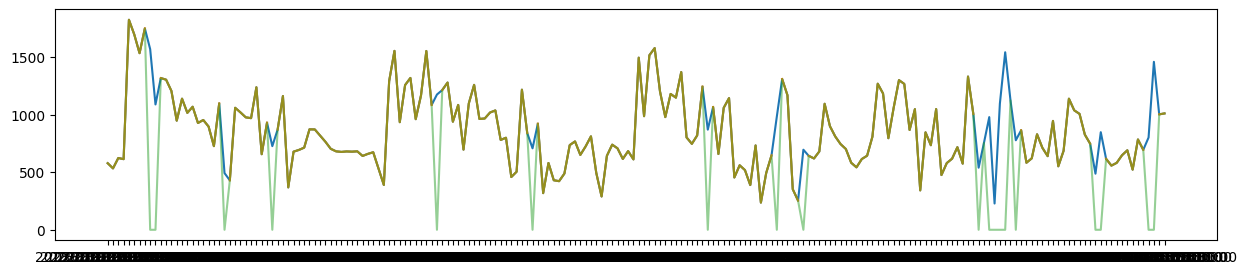

In [111]:
fig, ax = fig_ax()
ax.plot(data_train["holed_1"][0:200], alpha=1)
ax.plot(TS_missing["holed_1"][0:200])
ax.plot(ts_interpolated[0:200], alpha=0.5)
plt.show()

In [81]:
serie_list_AR = []
for serie in tqdm(test_series):
    serie_list_AR.append(ar_interpolation_optimized(TS_missing.loc[:,serie], p=1))

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_50040/298694656.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  known_x = x_interpolated[known_idx]
/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_50040/298694656.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d[i] += sum(ar_coeffs[:p - abs(k)]) * x_interpolated[t - k]
/var/folders/tn/md278c0j7rn5h9f_28zsysl00000gn/T/ipykernel_50040/298694656.py:63: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

In [82]:
np.isnan(serie_list_AR).sum()

np.int64(0)

In [83]:
serie_list_AR = np.array(serie_list_AR)
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_AR.T[missing_idx])
print(mae)

312.23586211138104


## 5. Vector Auto Regressive Interpolation

In [38]:
pca = PCA(n_components=81)
feature_pca = pca.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca = pd.DataFrame(feature_pca, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca.shape[1])])
feature_pca.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,-25856.843481,19083.073312,-11412.651173,-4753.162365,-4151.186807,-7914.224300,6504.943954,-2683.676409,2904.774263,11100.809269,...,242.678940,207.758188,-1129.310841,-1036.801439,-2445.193094,1224.029270,427.410063,371.414164,1883.144289,-1363.334634
2023-01-09 00:30:00,-27215.683251,19324.017477,-8413.899442,-3486.260044,-4401.667389,-5994.585480,8764.791329,-4138.396100,3612.403925,10118.083053,...,-566.507244,19.436998,-1586.576258,1041.295496,-3327.455397,2394.664765,1729.069115,-734.787606,3031.473735,-1814.036672
2023-01-09 01:00:00,-28829.713192,18679.817680,-3772.600132,559.605766,-4800.692059,-3131.299046,10711.855967,-4611.373375,3445.002352,6516.491540,...,-486.953472,1815.339926,-1844.070331,-1084.164479,-2436.187749,3477.283282,1670.072318,-56.678186,1599.547280,471.707119
2023-01-09 01:30:00,-29753.089982,17644.940864,1279.580673,3985.666959,-4079.146033,-217.299171,11771.634284,-5509.796990,1525.805170,3688.937118,...,-156.806451,1214.191794,25.439845,-1156.209495,-2324.234970,3824.531827,1978.272199,539.716810,-1127.512436,270.464505
2023-01-09 02:00:00,-28382.902443,17045.986468,6716.731995,6834.332990,-2988.195347,3912.338633,11387.613224,-5162.090219,-1144.539151,1684.239751,...,695.346450,1322.167057,890.087220,-1131.952753,-342.721719,1803.656971,2790.750251,-116.420279,-1427.440176,481.032411


In [39]:
def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values

    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def var_based_interpolation(holed_series, pca_series, lag_order=5):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # Trouver les indices des valeurs manquantes
    missing_mask = holed_series.isna()

    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)

    # Séparer les données connues et manquantes
    train_data = combined_data.dropna()  # Entraînement sur les données complètes
    
    # Entraîner le modèle VAR
    var_model = VAR(train_data.values)
    try:
        var_results = var_model.fit(lag_order)
    except:
        var_results = var_model.fit(lag_order, trend='n')

    # Prédiction des valeurs manquantes
    for col in holed_series.columns:
        missing_idx = holed_series[col][missing_mask[col]].index

        for idx in missing_idx:
            # Récupérer les données passées pour la prédiction
            
            past_data = fill_past_data(combined_data, idx, lag_order)

            prediction = var_results.forecast(past_data, steps=1)[0]

            # Affecter la prédiction dans la série interpolée
            holed_series_interpolated.loc[idx, col] = prediction[0]  # Premier élément est la série cible

    return holed_series_interpolated

In [40]:
# holed_series_interpolated = var_based_interpolation(TS_missing[['1_holed']], feature_pca, lag_order=longest_missing_segment(TS_missing[['1_holed']]))
holed_series_interpolated = pd.DataFrame()
error = 0
count = 0
for serie in tqdm(df_test_missing.columns):
    missing_idx = df_test_missing[serie].isna()
    series_interpolated = var_based_interpolation(df_test_missing[[serie]], feature_pca, lag_order=55)
    holed_series_interpolated = pd.concat([holed_series_interpolated,series_interpolated], axis=1)  
    # error += np.abs(data_train[serie][missing_idx]-series_interpolated[serie][missing_idx]).sum()
    # count += missing_idx.sum()
    
# print("MAE :",error/count)

100%|██████████| 1000/1000 [06:50<00:00,  2.43it/s]


In [41]:
holed_series_interpolated.to_csv("results/VAR_1_81.csv")

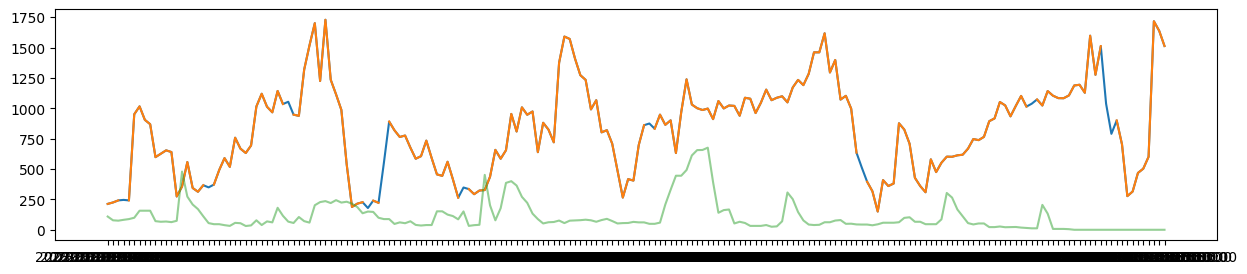

In [42]:
fig, ax = fig_ax()
ax.plot(data_train["holed_455"][200:400], alpha=1)
ax.plot(TS_missing["holed_455"][200:400])
ax.plot(holed_series_interpolated["holed_455"][200:400], alpha=0.5)
plt.show()

In [ ]:
holed_series_interpolated = pd.DataFrame()
error = 0
count = 0
for serie in tqdm(test_series):
    missing_idx = TS_missing[serie].isna()
    series_interpolated = var_based_interpolation(TS_missing[[serie]], feature_pca, lag_order=1)
    holed_series_interpolated = pd.concat([holed_series_interpolated,series_interpolated], axis=1)  
    error += np.abs(data_train[serie][missing_idx]-series_interpolated[serie][missing_idx]).sum()
    count += missing_idx.sum()

In [ ]:
print("MAE :",error/count)

## 6. VARMAX

In [34]:
pca_VARMA = PCA(n_components=20)
feature_pca_VARMA = pca_VARMA.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca_VARMA = pd.DataFrame(feature_pca_VARMA, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca_VARMA.shape[1])])

In [35]:
def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values

    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def varma_based_interpolation(holed_series, pca_series, order=(2,1)):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # Trouver les indices des valeurs manquantes
    missing_mask = holed_series.isna()

    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    # combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)

    # Séparer les données connues et manquantes
    # train_data = combined_data.dropna()  # Entraînement sur les données complètes
    
    # Entraîner le modèle VAR

    try:
        varma_model = VARMAX(endog=holed_series.values, exog=pca_series.values, order=order, trend='c')
        varma_results = varma_model.fit(disp=False)
        print('done')
    except:
        varma_model = VARMAX(endog=holed_series.values, exog=pca_series.values, order=order, trend='n')
        varma_results = varma_model.fit(disp=False)
        print('done')

    # Prédiction des valeurs manquantes
    for col in holed_series.columns:
        missing_idx = holed_series[col][missing_mask[col]].index

        for idx in missing_idx:
            # Récupérer les données passées pour la prédiction
            # past_values = combined_data.loc[:idx].dropna()

            prediction = varma_results.forecast(steps=1, exog=pca_series.loc[idx,:].values)[0]

            # Affecter la prédiction dans la série interpolée
            holed_series_interpolated.loc[idx, col] = prediction[0]  # Premier élément est la série cible

    return holed_series_interpolated

In [112]:
interpolated_series = varma_based_interpolation(TS_missing[['holed_1', 'holed_2']], feature_pca_VARMA, order=([1,2,3,48,49,50],0))

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

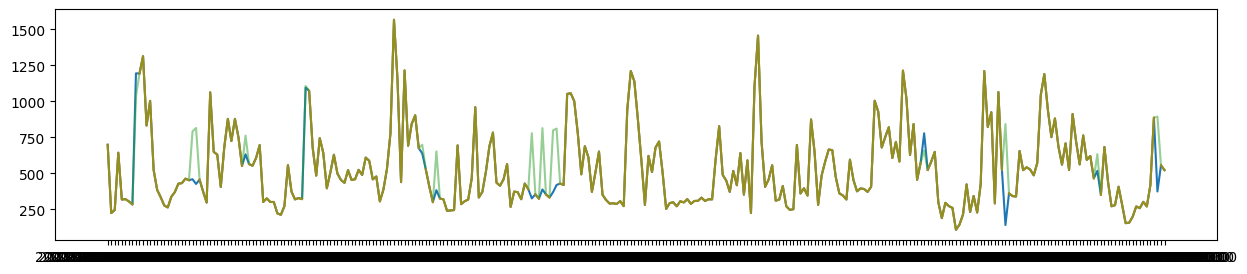

In [370]:
fig, ax = fig_ax()
ax.plot(data_train["holed_2"][0:300], alpha=1)
ax.plot(TS_missing["holed_2"][0:300])
ax.plot(interpolated_series["holed_2"][0:300], alpha=0.5)
plt.show()

## 7. SARIMAX

In [194]:
pca_SARIMAX = PCA(n_components=10)
feature_pca_SARIMAX = pca_SARIMAX.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca_SARIMAX = pd.DataFrame(feature_pca_SARIMAX, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca_SARIMAX.shape[1])])

In [218]:
def sarimax_based_interpolation(holed_series, pca_series, order=(2,1,0), seasonal_order=(0,0,0,0)):
    """
    Interpolation des valeurs manquantes à l'aide de SARIMAX.
    
    - Entraîne un modèle SARIMAX sur les parties connues des séries.
    - Utilise les séries PCA comme exogènes pour améliorer la précision.
    
    Paramètres :
    - holed_series : DataFrame contenant les séries trouées.
    - pca_series : DataFrame contenant les séries PCA complètes.
    - order : Ordre du modèle SARIMA (p, d, q).
    - seasonal_order : Ordre saisonnier du modèle (P, D, Q, s).

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs interpolées.
    """

    # 📌 S'assurer que les index sont bien alignés et de type DatetimeIndex
    if not isinstance(holed_series.index, pd.DatetimeIndex):
        holed_series.index = pd.to_datetime(holed_series.index)
        pca_series.index = pd.to_datetime(pca_series.index)
    holed_series_interpolated = holed_series.copy()
    # 📌 Aligner `holed_series` et `pca_series`
    pca_series = pca_series.reindex(holed_series.index)  # Force l'alignement des indices
    # 📌 Trouver les indices des valeurs manquantes
    missing_mask = holed_series.isna()

    # 📌 Supprimer les NaN pour entraîner le modèle
    train_data = holed_series.dropna()
    exog_train = pca_series.loc[train_data.index]
    # 📌 Vérifier que les indices sont bien alignés après `reindex()`
    if not train_data.index.equals(exog_train.index):
        raise ValueError("Les indices de `train_data` et `exog_train` ne sont pas alignés après `reindex()`")

    # 📌 Entraîner le modèle SARIMAX
    try:
        # model = SARIMAX(endog=train_data, exog=exog_train, order=order, seasonal_order=seasonal_order, trend='c')
        model = SARIMAX(endog=pca_series.iloc[:,0], order=order, seasonal_order=seasonal_order, trend='c')
        model_results = model.fit(disp=False)
        print('✅ Modèle entraîné avec trend "c"')
    except:
        # model = SARIMAX(endog=train_data, exog=exog_train, order=order, seasonal_order=seasonal_order, trend='n')
        model = SARIMAX(endog=pca_series.iloc[:,0], order=order, seasonal_order=seasonal_order, trend='n')
        model_results = model.fit(disp=False)
        print('⚠️ Trend "c" a échoué, modèle entraîné avec trend "n"')

    # 📌 Prédiction des valeurs manquantes
    for col in holed_series.columns:
        missing_idx = missing_mask[col][missing_mask[col]].index  # Indices des NaN

        for idx in missing_idx:
            # 📌 Vérifier que `idx` existe bien dans `pca_series`
            if idx not in pca_series.index:
                print(f"❌ Exogènes indisponibles pour {idx}, impossible de prédire {col}.")
                continue

            # 📌 Récupérer les features PCA associées à `idx`
            exog_data = pca_series.loc[[idx]].values  # Doit être sous forme de DataFrame (1, N)

            # 📌 Prédiction avec SARIMAX
            # prediction = model_results.forecast(steps=1, exog=exog_data)
            prediction = model_results.forecast(steps=1)

            # ✅ Correction : Convertir `prediction` en scalaire
            predicted_value = prediction.iloc[0] if isinstance(prediction, pd.Series) else prediction[0]
            # print(f"🔮 Prédiction pour {col} à {idx} : {predicted_value}")

            # 📌 Remplir la valeur prédite dans la série
            # print(holed_series_interpolated.loc[idx, col])
            holed_series_interpolated.loc[idx, col] = float(predicted_value)

    return holed_series_interpolated


In [219]:
interpolated_series = sarimax_based_interpolation(TS_missing[['holed_8']], feature_pca_SARIMAX, order=(1,1,0), seasonal_order=(3,0,0,49))

/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


✅ Modèle entraîné avec trend "c"


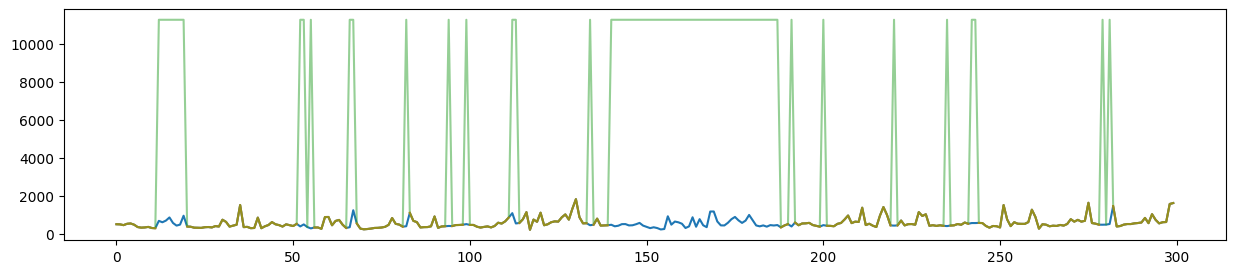

In [220]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:400].values, alpha=1)
ax.plot(TS_missing["holed_8"][100:400].values)
ax.plot(interpolated_series["holed_8"][100:400].values, alpha=0.5)
plt.show()

In [148]:
interpolated_series.head(20)

,holed_1
Horodate,
2023-01-09 00:00:00,578.0
2023-01-09 00:30:00,533.0
2023-01-09 01:00:00,623.0
2023-01-09 01:30:00,613.0
2023-01-09 02:00:00,1823.0
2023-01-09 02:30:00,1696.0
2023-01-09 03:00:00,1533.0
2023-01-09 03:30:00,1748.0
2023-01-09 04:00:00,NaN


## 8. LSTM

In [467]:
def detect_missing_sequences(series):
    """
    Détecte les séquences de valeurs manquantes consécutives.
    
    Retourne une liste de tuples (start_idx, end_idx) indiquant les blocs de NaN.
    """
    missing_sequences = []
    in_missing_block = False

    for i in range(len(series)):
        if np.isnan(series[i]) and not in_missing_block:
            start_idx = i
            in_missing_block = True
        elif not np.isnan(series[i]) and in_missing_block:
            end_idx = i - 1
            missing_sequences.append((start_idx, end_idx))
            in_missing_block = False

    # Si la série se termine par des NaN
    if in_missing_block:
        missing_sequences.append((start_idx, len(series) - 1))

    return missing_sequences

def prepare_lstm_data(holed_series, pca_series, lookback=10):
    """
    Prépare les données pour entraîner la LSTM.

    - Construit des séquences temporelles (`lookback` timesteps).
    - Normalise les données.
    
    Retourne :
    - X_train, y_train : Données d'entraînement.
    - X_test, missing_idx : Données pour prédire les valeurs manquantes.
    - scaler : Scaler utilisé pour la normalisation.
    """

    # Concaténer les séries trouées et les PCA
    combined_data = pd.concat([holed_series, pca_series], axis=1) # (T, N)

    # Normalisation des données
    scaler = MinMaxScaler()
    combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), 
                                        columns=combined_data.columns, 
                                        index=combined_data.index)

    X_train, y_train = [], []

    for col in holed_series.columns:
        series = combined_data_scaled[col].values  # 📌 Seule la série cible est prise dans `y_train`
        missing_sequences = detect_missing_sequences(holed_series[col].values)

        for i in range(lookback, len(series)):
            if any(start <= i <= end for start, end in missing_sequences):
                continue  # On ne prend pas les NaN pour l'entraînement

            # 📌 Construire `X_train` avec les valeurs passées de `holed_series` ET `pca_series`
            past_values = combined_data_scaled.iloc[i-lookback:i].values  # (lookback, N)
            if np.isnan(past_values).any():
                continue
            pca_features = pca_series.iloc[i-lookback:i].values  # (N_pca,)
            full_features = np.concatenate([past_values.flatten(), pca_features.flatten()])  # (lookback * N + N_pca,)
            print(full_features.shape)
            if np.isnan(full_features).any():
                print(i)
            X_train.append(full_features)
            y_train.append(series[i])  # 📌 `y_train` contient uniquement `holed_series[col]`

    return np.array(X_train), np.array(y_train), scaler

def build_lstm_model(input_shape):
    """
    Construit un modèle LSTM pour interpoler les valeurs manquantes.
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mae')
    return model

def lstm_interpolation(holed_series, pca_series, lookback=10, epochs=20, batch_size=16):
    """
    Applique une interpolation basée sur un modèle LSTM en prenant en compte toutes les séries trouées + PCA.

    - Entraîne un modèle sur les données connues.
    - Prédit les valeurs manquantes séquentiellement en utilisant toutes les séries trouées et les PCA.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # 📌 Préparation des données
    X_train, y_train, scaler = prepare_lstm_data(holed_series, pca_series, lookback)

    # ✅ Stocker l'ordre des colonnes après le fit
    expected_columns = list(pd.concat([holed_series, pca_series], axis=0).columns)

    # 📌 Vérifier si on a des données d'entraînement valides
    if len(X_train) < 2:
        print("⚠️ Pas assez de données pour entraîner la LSTM.")
        return holed_series_interpolated

    # 📌 Construire et entraîner le modèle LSTM
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # 📌 Interpolation séquentielle bloc par bloc
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col].values)

        for start_idx, end_idx in missing_sequences:
            if start_idx > lookback:
                for idx in range(start_idx, end_idx + 1):
                    # 📌 Récupérer les valeurs passées de toutes les séries trouées
                    input_sequence = holed_series_interpolated.iloc[idx - lookback:idx].values
                    print(start_idx)
                    # 📌 Si NaN présents, remplir avec la moyenne des valeurs connues
                    nan_mask = np.isnan(input_sequence)
                    if np.any(nan_mask):
                        mean_values = np.nanmean(holed_series_interpolated.iloc[:idx].values, axis=0)
                        input_sequence[nan_mask] = np.take(mean_values, np.where(nan_mask)[1])

                    # 📌 Ajouter les valeurs PCA correspondantes
                    pca_features = pca_series.iloc[idx - lookback:idx].values
                    
                    # 📌 Construire le DataFrame avec toutes les séries trouées + PCA
                    # print(input_sequence.flatten().shape, pca_features.shape)
                    full_features = np.concatenate([input_sequence.flatten(), pca_features.flatten()])
                    # print(full_features)
                    # full_features_df = pd.DataFrame(full_features, columns=expected_columns)

                    # ✅ Vérifier que les colonnes sont bien dans le bon ordre
                    # full_features_df = full_features_df.reindex(columns=expected_columns, fill_value=0)

                    # 📌 Normaliser l'entrée
                    full_features_scaled = scaler.transform(full_features)
                    input_sequence_scaled = np.array(full_features_scaled).reshape((1, X_train.shape[1], 1))

                    # 📌 Prédire la valeur manquante
                    pred_scaled = model.predict(input_sequence_scaled)
                    pred = scaler.inverse_transform([[pred_scaled[0, 0]]])[0, 0]

                    # 📌 Remplir la valeur prédite dans la série
                    holed_series_interpolated.loc[idx, col] = pred

    return holed_series_interpolated

In [459]:
holed_series = TS_missing[['holed_1','holed_2']].copy()
pca = PCA(n_components=20)
test_pca = pca.fit_transform(df_test_complete)
test_pca = pd.DataFrame(test_pca, index=holed_series.index, columns=[f"feature_{i}" for i in range(test_pca.shape[1])])

In [468]:
holed_series_interpolated = lstm_interpolation(holed_series,test_pca, 10, 1, 16)

(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)

/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

# Model Rankings

| Méthode                     | Score / MAE |
|-----------------------------|------------:|
| **XGBOOST_PCA**             | 104    |
| **Benchmark**               | 116.1044    |
| **A battre**                | 92.8029     |
| **Interpolation Cubique**    | 29038  |
| **Interpolation Spline**     | 29038  |
| **Interpolation Linéaire**   | 107.7838   |
| **Low Rank Adaptation**      | 193.39  |
| **AR interpolation**      | 312 |
| **VAR interpolation (1)**      | 102 |
